### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code

### Parameters

In [2]:
rotation_symmetries = [2, 3, 4]
loss_noise_values = [0.1, 0.05, 0.03, 0.01]
average_photon_numbers = range(1, 4)
number_of_random_code_trials = 80

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = [code_simulator.get_fidelity_of_code_under_loss_noise(code.trivial_code, loss_noise_amount, False) for loss_noise_amount in loss_noise_values]

### Fidelities of Binomial Code

This will take forever to run on the first time because it needs to calculate a lot of stuff, but subsequent runs should be near instantaneous because all the calculation values are saved to files.

In [4]:
%%time

binomial_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), 2))
binomial_photon_numbers = np.zeros((len(rotation_symmetries), len(average_photon_numbers)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
			binomial_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, False)
			binomial_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, True)
			binomial_photon_numbers[i,k] = qt.expect(qt.num(binomial_code.physical_dimension), 1 / 2 * (binomial_code.zero_encoding * binomial_code.zero_encoding.dag() + binomial_code.one_encoding * binomial_code.one_encoding.dag()))

CPU times: user 32.1 ms, sys: 4.86 ms, total: 36.9 ms
Wall time: 36.1 ms


### Fidelities of Cat Code

This will take a bit to run on the first time, but will be near-instantaneous after.

In [5]:
%%time

coherent_state_values = range(1, average_photon_numbers[-1])
cat_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(coherent_state_values), 2))
cat_photon_numbers = np.zeros((len(rotation_symmetries), len(coherent_state_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, coherent_state_value in enumerate(coherent_state_values):
			cat_code = code.get_cat_code(rotation_symmetry, coherent_state_value, 0, max(int(coherent_state_value ** 2 + 2.2 * coherent_state_value) + 1, rotation_symmetry + 1))
			cat_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(cat_code, loss_noise_amount, False)
			cat_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(cat_code, loss_noise_amount, True)
			cat_photon_numbers[i,k] = qt.expect(qt.num(cat_code.physical_dimension), 1 / 2 * (cat_code.zero_encoding * cat_code.zero_encoding.dag() + cat_code.one_encoding * cat_code.one_encoding.dag()))

CPU times: user 19.7 ms, sys: 2.81 ms, total: 22.6 ms
Wall time: 21.9 ms


### Fidelities of Haar Random Codes

This will probably always take a bit.

In [6]:
%%time

haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				haar_random_code = code.make_haar_random_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
				haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of_code_under_loss_noise(haar_random_code, loss_noise_amount, False)
				haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of_code_under_loss_noise(haar_random_code, loss_noise_amount, True)
				haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(haar_random_code.physical_dimension), 1 / 2 * (haar_random_code.zero_encoding * haar_random_code.zero_encoding.dag() + haar_random_code.one_encoding * haar_random_code.one_encoding.dag()))

CPU times: user 9min 38s, sys: 8min 2s, total: 17min 41s
Wall time: 20min 28s


### Fidelities of Expanded Haar Random Codes

This will probably always take a bit.

In [7]:
%%time

expanded_haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
expanded_haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				expanded_haar_random_code = code.make_expanded_haar_random_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
				expanded_haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of_code_under_loss_noise(expanded_haar_random_code, loss_noise_amount, False)
				expanded_haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of_code_under_loss_noise(expanded_haar_random_code, loss_noise_amount, True)
				expanded_haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(expanded_haar_random_code.physical_dimension), 1 / 2 * (expanded_haar_random_code.zero_encoding * expanded_haar_random_code.zero_encoding.dag() + expanded_haar_random_code.one_encoding * expanded_haar_random_code.one_encoding.dag()))

CPU times: user 9min 6s, sys: 8min 12s, total: 17min 19s
Wall time: 16min 54s


### Fidelities of Split Expanded Haar Random Codes

This will probably always take a bit.

In [8]:
%%time

split_expanded_haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
split_expanded_haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				split_expanded_haar_random_code = code.make_split_expanded_haar_random_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
				split_expanded_haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of_code_under_loss_noise(split_expanded_haar_random_code, loss_noise_amount, False)
				split_expanded_haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of_code_under_loss_noise(split_expanded_haar_random_code, loss_noise_amount, True)
				split_expanded_haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(split_expanded_haar_random_code.physical_dimension), 1 / 2 * (split_expanded_haar_random_code.zero_encoding * split_expanded_haar_random_code.zero_encoding.dag() + split_expanded_haar_random_code.one_encoding * split_expanded_haar_random_code.one_encoding.dag()))

CPU times: user 11min 12s, sys: 8min 31s, total: 19min 44s
Wall time: 8min 56s


### Plots of Error Rates vs. Average Number

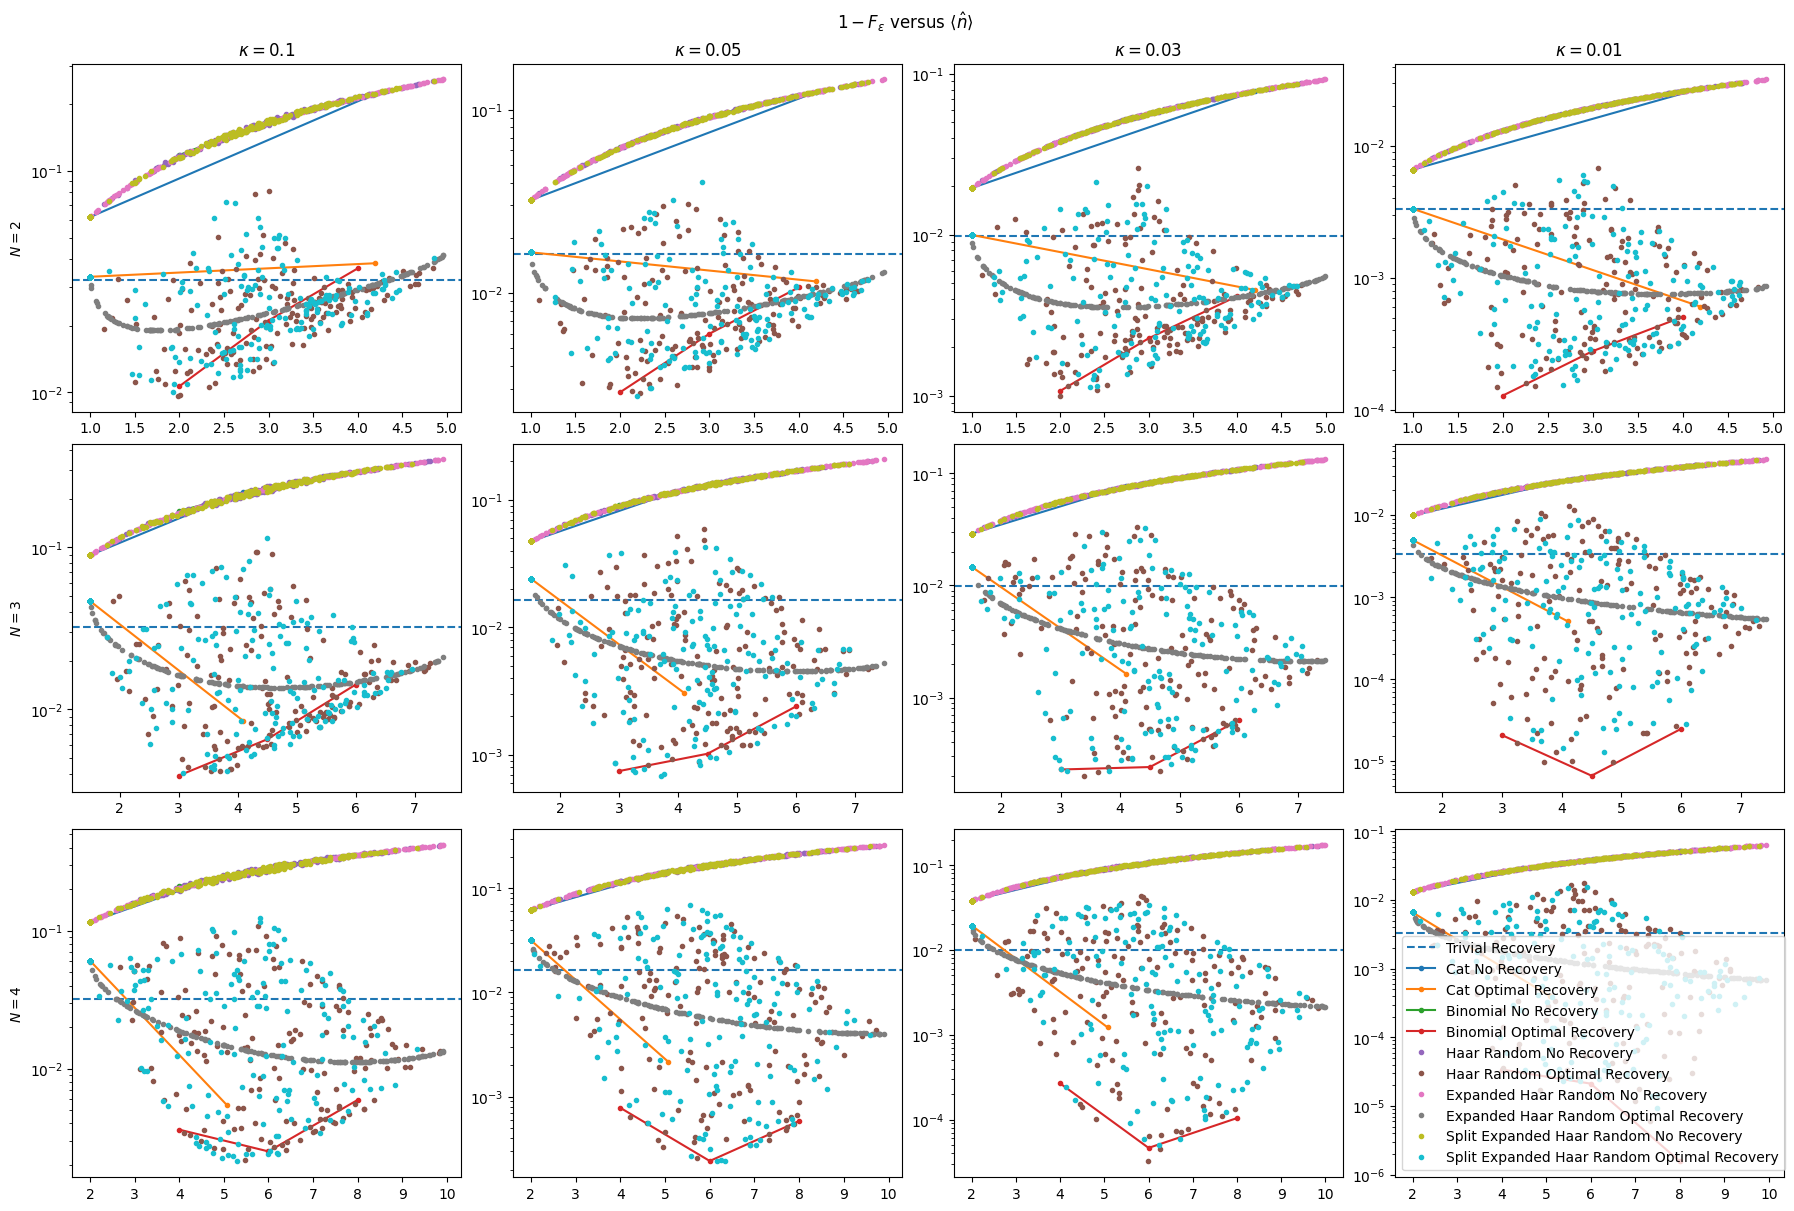

In [9]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

largest_x_limits = [float("infinity"), -float("infinity")]
largest_y_limits = [float("infinity"), -float("infinity")]
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(haar_random_photon_numbers[i,j,:,:].flatten(), 1 - haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Haar Random No Recovery")
		axs[i,j].semilogy(haar_random_photon_numbers[i,j,:,:].flatten(), 1 - haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Haar Random Optimal Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Expanded Haar Random No Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Expanded Haar Random Optimal Recovery")
		axs[i,j].semilogy(split_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - split_expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Split Expanded Haar Random No Recovery")
		axs[i,j].semilogy(split_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - split_expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Split Expanded Haar Random Optimal Recovery")
		xlimits = axs[i,j].get_xlim()
		ylimits = axs[i,j].get_ylim()
		if xlimits[0] < largest_x_limits[0]:
			largest_x_limits[0] = xlimits[0]
		if xlimits[1] > largest_x_limits[1]:
			largest_x_limits[1] = xlimits[1]
		if ylimits[0] < largest_y_limits[0]:
			largest_y_limits[0] = ylimits[0]
		if ylimits[1] > largest_y_limits[1]:
			largest_y_limits[1] = ylimits[1]

axs[-1,-1].legend()
plt.show()

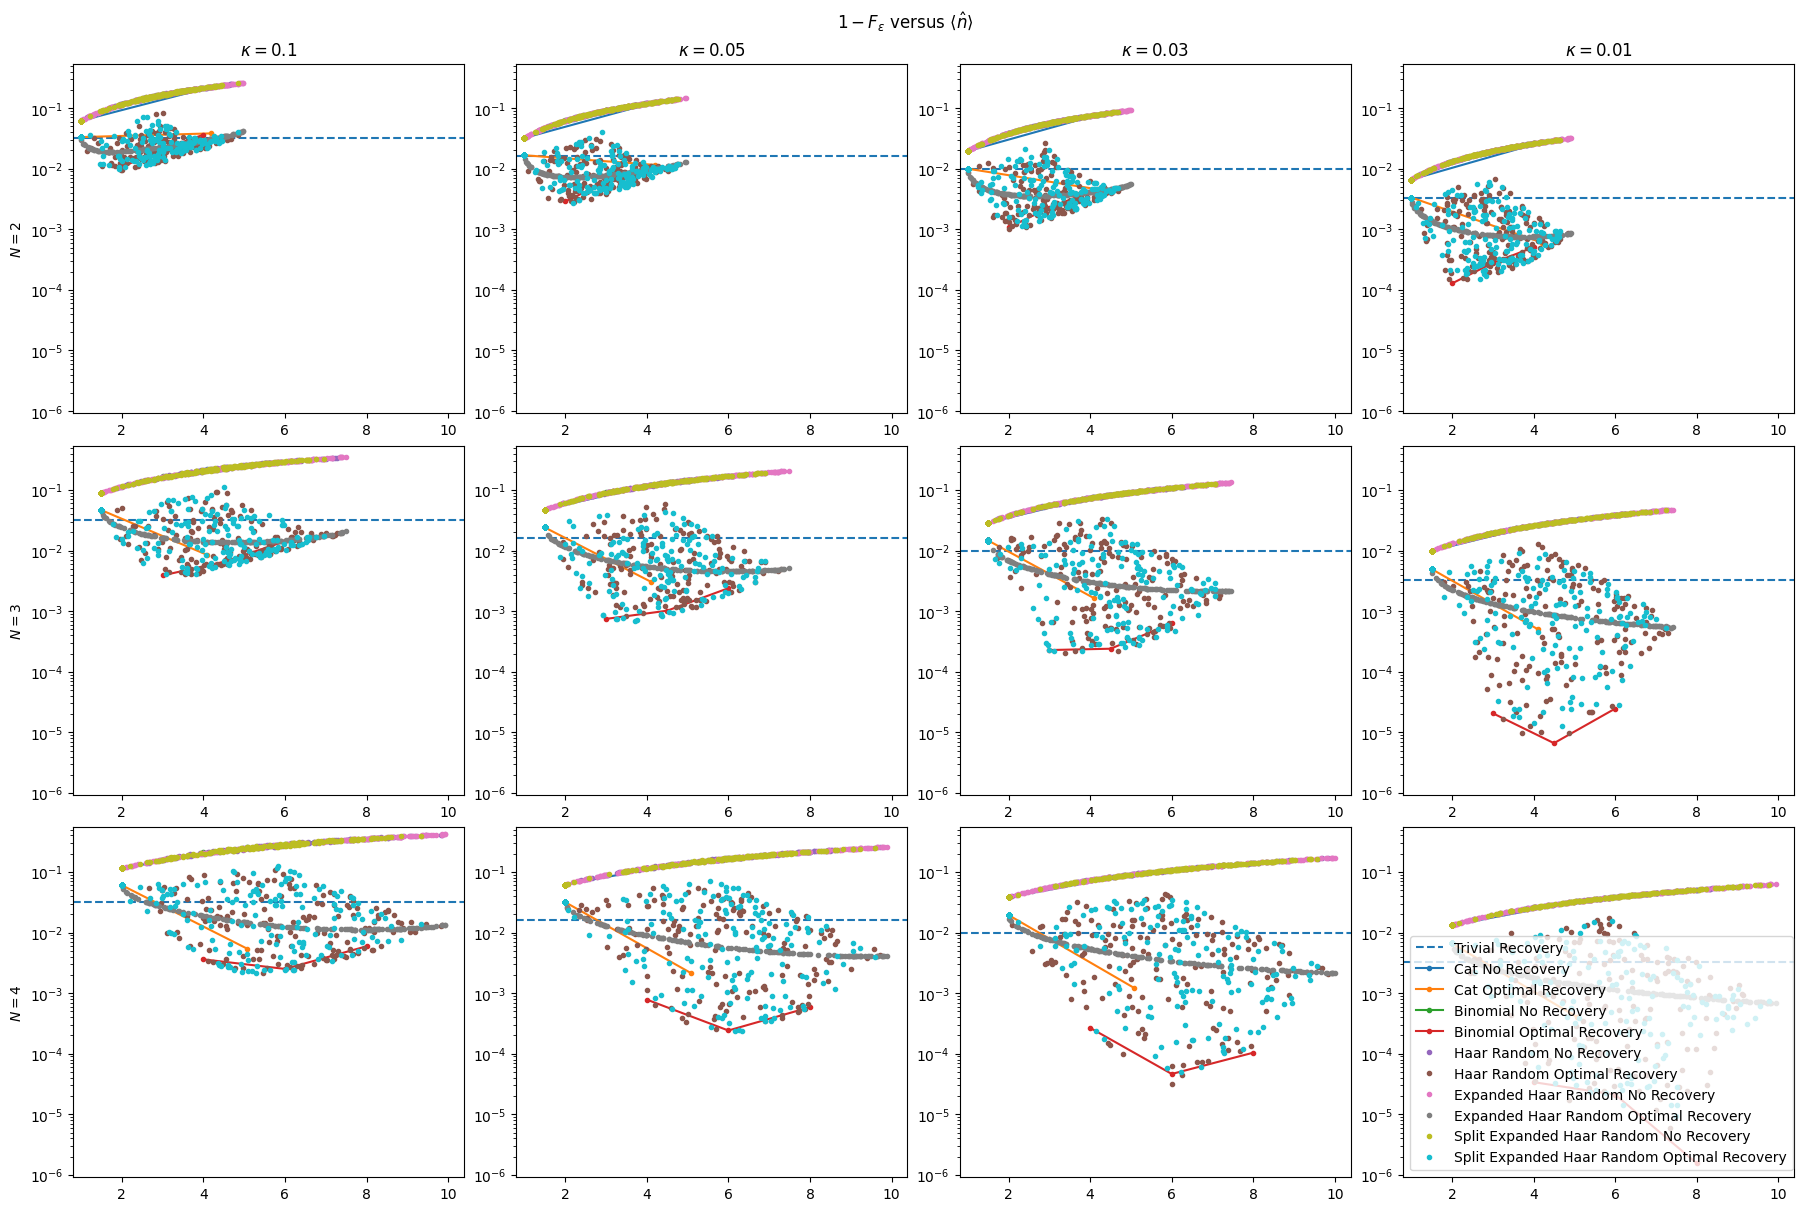

In [10]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].set_xlim(largest_x_limits)
		axs[i,j].set_ylim(largest_y_limits)
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(haar_random_photon_numbers[i,j,:,:].flatten(), 1 - haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Haar Random No Recovery")
		axs[i,j].semilogy(haar_random_photon_numbers[i,j,:,:].flatten(), 1 - haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Haar Random Optimal Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Expanded Haar Random No Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Expanded Haar Random Optimal Recovery")
		axs[i,j].semilogy(split_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - split_expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Split Expanded Haar Random No Recovery")
		axs[i,j].semilogy(split_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - split_expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Split Expanded Haar Random Optimal Recovery")

axs[-1,-1].legend()
plt.show()

### Comparison of Random Codes

TODO